In [1]:
import numpy as np
from ruamel.yaml import YAML
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Polygon
from IPython.display import clear_output
import torch
import sys
import pandas as pd
import tarfile
import math
import warnings
import os
import math
import csv
import utils
import gym
import argparse
import datetime
import pandas as pd
from IPython.display import clear_output, display
import json

warnings.filterwarnings('ignore')


In [2]:
def get_data_dir():
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    print(current_dir)
    return os.path.join(current_dir, "experiment_data", "data_generation")


In [3]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [4]:
def derived_papi(PAPI_data):
    DERIVED = {}
    DERIVED['TOT_INS_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_INS'].time)
    })
    DERIVED['TOT_CYC_PER_INS'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_CYC'].time)
    })
    DERIVED['L3_TCM_PER_TCA'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_L3_TCM']['instantaneous_value']) / np.array(PAPI_data['PAPI_L3_TCA']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_L3_TCM'].time)
    })  
    DERIVED['TOT_STL_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_RES_STL']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_RES_STL'].time)
    })
    
    # Create a mask for non-NaN values across all keys
    mask = ~DERIVED['TOT_INS_PER_CYC']['value'].isna()  # Start with one key to create the mask
    for key in DERIVED:
        mask &= ~DERIVED[key]['value'].isna()  # Combine masks for all keys

    for key in DERIVED:
        DERIVED[key] = DERIVED[key][mask]  # Filter each DataFrame using the combined mask

    return DERIVED

def calculate_power_with_wraparound(current, previous, time_diff, wraparound_value=262143.328850):
    diff = current - previous
    if diff < 0:  # Wraparound detected
        diff = (wraparound_value - previous) + current
    return diff / time_diff

def compute_power(pubEnergy):
    power = {}
    geopm_sensor0 = geopm_sensor1 = pd.DataFrame({'timestamp':[],'value':[]})
    for i,row in pubEnergy.iterrows():
        if i%2 == 0:
            geopm_sensor0 = pd.concat([geopm_sensor0, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)
        else:
            geopm_sensor1 = pd.concat([geopm_sensor1, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)


    power['geopm_power_0'] = pd.DataFrame({
        'timestamp': geopm_sensor0['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor0['value'][i],
                geopm_sensor0['value'][i-1],
                geopm_sensor0['timestamp'][i] - geopm_sensor0['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor0))
        ]
    })

    # Apply the same logic to geopm_power_1
    power['geopm_power_1'] = pd.DataFrame({
        'timestamp': geopm_sensor1['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor1['value'][i],
                geopm_sensor1['value'][i-1],
                geopm_sensor1['timestamp'][i] - geopm_sensor1['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor1))
        ]
    })

    min_length = min(len(power['geopm_power_0']), len(power['geopm_power_1']))
    geopm_power_0 = power['geopm_power_0'][:min_length]
    geopm_power_1 = power['geopm_power_1'][:min_length]

    average_power = pd.DataFrame({
        'timestamp': geopm_power_0['timestamp'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['power'], geopm_power_1['power'])]
    })
    average_power['elapsed_time'] = average_power['timestamp'] - average_power['timestamp'].iloc[0]
    power['average_power'] = average_power
    return power

def measure_progress(progress_data, energy_data):
    Progress_DATA = {} 
    progress_sensor = pd.DataFrame(progress_data)
    first_sensor_point = min(energy_data['average_power']['timestamp'].iloc[0], progress_sensor['time'][0])
    progress_sensor['elapsed_time'] = progress_sensor['time'] - first_sensor_point  # New column for elapsed time
    # progress_sensor = progress_sensor.set_index('elapsed_time')
    performance_elapsed_time = progress_sensor.elapsed_time
    # Add performance_frequency as a new column in progress_sensor
    frequency_values = [
        progress_data['value'].iloc[t] / (performance_elapsed_time[t] - performance_elapsed_time[t-1]) for t in range(1, len(performance_elapsed_time))
    ]
    
    # Ensure the frequency_values length matches the index length
    frequency_values = [0] + frequency_values  # Prepend a 0 for the first index
    progress_sensor['frequency'] = frequency_values
    upsampled_timestamps= energy_data['average_power']['timestamp']
    
    # true_count = (progress_sensor['time'] <= upsampled_timestamps.iloc[0]).sum()

    progress_frequency_median = pd.DataFrame({'median': np.nanmedian(progress_sensor['frequency'].where(progress_sensor['time'] <= upsampled_timestamps.iloc[0])), 'timestamp': upsampled_timestamps.iloc[0]}, index=[0])
    for t in range(1, len(upsampled_timestamps)):
        progress_frequency_median = pd.concat([progress_frequency_median, pd.DataFrame({'median': [np.nanmedian(progress_sensor['frequency'].where((progress_sensor['time'] >= upsampled_timestamps.iloc[t-1]) & (progress_sensor['time'] <= upsampled_timestamps.iloc[t])))],
        'timestamp': [upsampled_timestamps.iloc[t]]})], ignore_index=True)
    progress_frequency_median['elapsed_time'] = progress_frequency_median['timestamp'] - progress_frequency_median['timestamp'].iloc[0]
    # Assign progress_frequency_median as a new column
    Progress_DATA['progress_sensor'] = progress_sensor
    Progress_DATA['progress_frequency_median'] = progress_frequency_median
    return Progress_DATA

def collect_papi(PAPI_data):
    PAPI = {}
    for scope in PAPI_data['scope'].unique():
        # Extract the string between the 3rd and 4th dots
        scope_parts = scope.split('.')
        if len(scope_parts) > 4:  # Ensure there are enough parts
            extracted_scope = scope_parts[3]
            # Aggregate the data for the extracted scope using pd.concat
            PAPI[extracted_scope] = PAPI_data[PAPI_data['scope'] == scope]
            instantaneous_values = [0] + [PAPI[extracted_scope]['value'].iloc[k] - PAPI[extracted_scope]['value'].iloc[k-1] for k in range(1,len(PAPI[extracted_scope]))]
            # Normalize the instantaneous values between 0 and 10
            # min_val = min(instantaneous_values)
            # max_val = max(instantaneous_values)
            PAPI[extracted_scope]['instantaneous_value'] = instantaneous_values
            PAPI[extracted_scope]['elapsed_time'] = PAPI[extracted_scope]['time'] - PAPI[extracted_scope]['time'].iloc[0]
    return PAPI


def generate_PCAP(PCAP_data):
    for row in PCAP_data.iterrows():
        if row[1]['time'] == 0:
            PCAP_data = PCAP_data.drop(row[0])


    PCAP_data['elapsed_time'] = PCAP_data['time'] - PCAP_data['time'].iloc[0]
    return PCAP_data


In [5]:
DATA_DIR = get_data_dir()
root,folders,files = next(os.walk(DATA_DIR))
training_data = {}
for APP in folders:
    APP_DIR = os.path.join(DATA_DIR, APP)
    training_data[APP] = {}
    for file in next(os.walk(APP_DIR))[2]:
        training_data[APP][file] = {}
        if file.endswith('.tar'):
            tar_path = os.path.join(APP_DIR, file)
            extract_dir = os.path.join(APP_DIR, file[:-4])  
            
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
            
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=extract_dir)
            
        pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
        pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
        pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
        pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
        # with open(f'{extract_dir}/parameters.yaml', 'r') as f:
        #     yaml = YAML(typ='safe', pure=True)
        #     parameters = yaml.load(f)
        #     PCAP = parameters['PCAP']
        # training_data['data']['PCAP'] = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
        training_data[APP][file]['power'] = compute_power(pubEnergy)
        training_data[APP][file]['progress'] = measure_progress(pubProgress,training_data[APP][file]['power'])
        training_data[APP][file]['papi'] = collect_papi(pubPAPI)
        training_data[APP][file]['PCAP'] = generate_PCAP(pubPCAP)
        training_data[APP][file]['derived_papi'] = derived_papi(training_data[APP][file]['papi'])   
        # print(training_data[APP][file]['PCAP'] )    
# training_data = normalize(training_data)

/Users/akhileshraj/Desktop/summer2024/main_codes


In [6]:
# APP = 'ones-stream-add'
# file = list(training_data[APP].keys())[0]
# training_data[APP][file]['derived_papi']

In [7]:
T_S = 1
ACTIONS = [78.0, 83.0, 89.0, 95.0, 101.0, 107.0, 112.0, 118.0, 124.0, 130.0, 136.0, 141.0, 147.0, 153.0, 159.0, 165.0]
exec_steps = 10000    
TOTAL_ACTIONS = len(ACTIONS)                                                                                                  # Total clock cycles needed for the execution of program.
ACTION_MIN = min(ACTIONS)                                                                                                    # Minima of control space
ACTION_MAX = max(ACTIONS)                                                                                                     # Maxima of control space
ACT_MID = ACTION_MIN + (ACTION_MAX - ACTION_MIN) / 2                                                                    # Midpoint of the control space to compute the normalized action space
# OBS_MAX = 300                                                                                                           # Maxima of observation space (performance)
# OBS_MIN = 0                           
OBS_MIN = np.zeros((5,))  # Shape should be (7,)
OBS_MAX = np.array([300,165,1,1,1])                                                                                 # Minima of observation space
OBS_MID = OBS_MIN + (OBS_MAX - OBS_MIN) / 2
EXEC_ITERATIONS = 10000
TOTAL_OBS = OBS_MAX - OBS_MIN
# print(TOTAL_ACTIONS)
OBS_ONEHOT = 'onehot'
OBS_RANDOM = 'random'
OBS_SMOOTH = 'smooth'


class SYS(object):
    def __init__(self,observation_type=OBS_ONEHOT,dim_obs=1,teps=0.0):
        super(SYS,self).__init__()

        self.num_actions = TOTAL_ACTIONS
        self.action_space = gym.spaces.Discrete(len(ACTIONS))  # Use the length of the ACTIONS list for discrete actions
        # Map the selected index to the corresponding action
        self.actions = ACTIONS  # Store the actions for later use
        self.observation_space = gym.spaces.Box(low=OBS_MIN, high=OBS_MAX, shape=(5,), dtype=np.float32)  # Infinite observation space with 8 dimensions

    
    def reward(self, s, a, ns, measured_power):
        """ 
        Returns the reward (float)
        """
        # measured_power = A[cluster] * a + B[cluster]
        if ns > 0:
            # self.current_step += ns
            # reward = - 5*a
            # reward = 2*ns/(((a)/measured_power)+measured_power) # Check the behaviour across the states
            reward = ns/(a**2+1)
            # reward = 5*a
        else:
            reward = -100
        # print(reward)
        return reward

weighting_only = False
dataset_composition = 'random'
dataset_size = 1000
env_type = 'random'
env = SYS(observation_type=env_type, dim_obs=8, teps=0)



In [8]:
def get_roi_data(df, time_column, start_time, end_time):
    return df[(df[time_column] > start_time) & (df[time_column] <= end_time)]


In [9]:
def get_state(td, app, trace, start_time, end_time):
    # print(app,trace,start_time,end_time)
    ROI_progress = get_roi_data(td[app][trace]['progress']['progress_frequency_median'], 'timestamp', start_time, end_time)
    ROI_measured_power = get_roi_data(td[app][trace]['power']['average_power'], 'timestamp', start_time, end_time)
    TOT_INS_PER_CYC = get_roi_data(td[app][trace]['derived_papi']['TOT_INS_PER_CYC'], 'timestamp', start_time, end_time)
    L3_TCM_PER_TCA = get_roi_data(td[app][trace]['derived_papi']['L3_TCM_PER_TCA'], 'timestamp', start_time, end_time)
    TOT_STL_PER_CYC = get_roi_data(td[app][trace]['derived_papi']['TOT_STL_PER_CYC'], 'timestamp', start_time, end_time)
    return (
        ROI_progress['median'].mean() if not ROI_progress.empty else 0,
        ROI_measured_power['average_power'].mean() if not ROI_measured_power.empty else 0,
        TOT_INS_PER_CYC['value'].mean() if not TOT_INS_PER_CYC.empty else 0,
        L3_TCM_PER_TCA['value'].mean() if not L3_TCM_PER_TCA.empty else 0,
        TOT_STL_PER_CYC['value'].mean() if not TOT_STL_PER_CYC.empty else 0,
    )


In [10]:

# training_data_csv = pd.read_csv('./merged_data.csv')
# PCAP = 0
# CURRENT_PRO = 0
# NEXT_PRO = 0
training_dataset = []
old_PCAP = 0
action_set = []
# Helper function to get state


# state_definition = [progress, measured_power, previous_PCAP, 'PAPI_L3_TCA', 'PAPI_TOT_INS', 'PAPI_TOT_CYC', 'PAPI_RES_STL', 'PAPI_L3_TCM']
initial_progress = 0
initial_power = 40
initial_PAPI = np.zeros(5)
state = (initial_progress,initial_power,initial_PAPI)
t1 = float('-inf')
for app in training_data:
    for trace in training_data[app]:
        pcap_data = training_data[app][trace]['PCAP']
        for i, row in pcap_data.iterrows():
            t2 = row['time']
            
            # Get current state
            state = get_state(training_data, app, trace, t1, t2)
            
            # Get next state (look ahead to next row)
            if i + 1 < len(pcap_data):
                t3 = pcap_data.iloc[i + 1]['time']
                next_state = get_state(training_data, app, trace, t2, t3)
            else:
                next_state = state  # Use current state if it's the last row
            
            action = row['value']  # Assuming PCAP is in the 'value' column
            
            # Calculate the reward
            reward = env.reward(state[0], action, next_state[0], state[1])
            
            # Add to training dataset
            training_dataset.append((state, action, reward, next_state))
            
            t1 = t2
print(len(training_dataset))
# training_dataset = [row for row in training_dataset if not any(pd.isna(value) for value in row)]

# Define the CSV file name and path
csv_file_name = 'training_dataset.csv'
csv_file_path = os.path.join(DATA_DIR, csv_file_name)

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)
    
    # Write the header
    csv_writer.writerow(['Progress', 'Power', 'TOT_INS_PER_CYC', 'L3_TCM_PER_TCA', 'TOT_STL_PER_CYC', 
                         'Action', 'Reward', 
                         'Next_Progress', 'Next_Power', 'Next_TOT_INS_PER_CYC', 'Next_L3_TCM_PER_TCA', 'Next_STL_PER_CYC'])
    
    for state, action, reward, next_state in training_dataset:
        # print(state,action,reward,next_state)
        if not (np.isnan(state).any() or np.isnan(action) or np.isnan(reward) or np.isnan(next_state).any()):
            if state[0] != 0 and next_state[0] != 0:
                row = list(state) + [action, reward] + list(next_state)
                csv_writer.writerow(row)


print(f"Training dataset has been saved to {csv_file_path}")


# Define the CSV file path
csv_file_path = f'{DATA_DIR}/training_dataset.csv'

# Load the CSV into a DataFrame
loaded_data = pd.read_csv(csv_file_path)
print(len(loaded_data))


1007
Training dataset has been saved to /Users/akhileshraj/Desktop/summer2024/main_codes/experiment_data/data_generation/training_dataset.csv
849


In [11]:
# Convert the DataFrame back to the original format (list of tuples)
training_dataset_loaded = [
    (
        tuple(row[:5]),  # State
        row[5],          # Action
        row[6],          # Reward
        tuple(row[7:])   # Next State
    )
    for row in loaded_data.values
]

print(len(training_dataset_loaded))


849


In [12]:
def stack_observations(env):
    obs = []
    for s in range(env.num_states):
        obs.append(env.observation(s))
    return np.stack(obs)

In [13]:
class FCNetwork(torch.nn.Module):
  def __init__(self, env, layers=[20,20]):
    super(FCNetwork, self).__init__()
    # self.all_observations = torch.tensor(stack_observations(env), dtype=torch.float32)
    dim_input = 5
    dim_output = env.num_actions
    net_layers = []

    dim = dim_input
    for i, layer_size in enumerate(layers):
      net_layers.append(torch.nn.Linear(dim, layer_size))
      net_layers.append(torch.nn.ReLU())
      dim = layer_size
    net_layers.append(torch.nn.Linear(dim, dim_output))
    self.layers = net_layers
    self.network = torch.nn.Sequential(*net_layers)

  def forward(self, states):
    # observations = torch.index_select(self.all_observations, 0, states)
    states_tensor = torch.tensor(states, dtype=torch.float32)  # Ensure the correct dtype
    return self.network(states_tensor)

  def print_weights(self):
    for name, param in self.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data.numpy()}")

In [14]:
def get_tensors(list_of_tensors, list_of_indices):
  s, a, ns, r = [], [], [], []
  for idx in list_of_indices:
    s.append(list_of_tensors[idx][0])
    a.append(list_of_tensors[idx][1])
    r.append(list_of_tensors[idx][2])
    ns.append(list_of_tensors[idx][3])
  s = np.array(s)
  a = np.array(a)
  ns = np.array(ns)
  r = np.array(r)
  return s, a, ns, r

In [15]:
def project_qvalues_cql_sampled(env, s, a, target_values, network, optimizer, cql_alpha=0.1, num_steps=50, weights=None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    # a = torch.tensor(a, dtype=torch.int64)
    a_indices = np.array([ACTIONS.index(action) for action in a])
    a_indices = torch.tensor(a_indices, dtype=torch.int64)
    pred_qvalues = network(s)
    logsumexp_qvalues = torch.logsumexp(pred_qvalues, dim=-1)

    pred_qvalues = pred_qvalues.gather(1, a_indices.reshape(-1,1)).squeeze()
    cql_loss = logsumexp_qvalues - pred_qvalues

    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    loss = loss + cql_alpha * torch.mean(cql_loss)

    network.zero_grad()
    loss.backward()
    optimizer.step()

    # pred_qvalues = network(torch.arange(env.num_states))
    return None

In [16]:
def project_qvalues_cql(q_values, network, optimizer, num_steps=50, cql_alpha=0.1, weights=None):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)

      # Add cql_loss
      # You can have two variants of this loss, one where data q-values
      # also maximized (CQL-v2), and one where only the large Q-values
      # are pushed down (CQL-v1) as covered in the tutorial
      cql_loss = torch.logsumexp(pred_qvalues, dim=-1, keepdim=True) # - pred_qvalues
      loss = loss + cql_alpha * torch.mean(weights * cql_loss)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

In [17]:
def q_backup_sparse_sampled(env, network, s, a, ns, r, discount=0.99):
  with torch.no_grad():  
    q_values_ns = network(ns)
  values = np.max(q_values_ns.detach().numpy(), axis=-1)
  target_value = r + discount * values
  return target_value


In [18]:
def conservative_q_iteration(env,
                             network, fig, axis,
                             num_itrs=100,
                             project_steps=50,
                             cql_alpha=0.1,
                             render=False,
                             weights=None,
                             sampled=False,
                             training_dataset=None,
                             log_file=None,
                             **kwargs):
  """
  Runs Conservative Q-iteration.

  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    cql_alpha (float): Value of weight on the CQL coefficient.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  print(log_file)
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

  # q_values = np.zeros((dS, dA)) #Initializing the Q-values for getting the target values
  # q_values = network(s)
  for i in range(num_itrs):
    for j in range(project_steps):
      training_idx = np.random.choice(np.arange(len(training_dataset)), size=32)
      s, a, ns, r = get_tensors(training_dataset, training_idx)
      target_values = q_backup_sparse_sampled(env, network, s, a, ns, r, **kwargs)
      project_qvalues_cql_sampled(
          env, s, a, target_values, network, optimizer,
          cql_alpha=cql_alpha, weights=None,
      )
      # if j == project_steps - 1:
      #   q_values = intermed_values
    # Create a CSV writer object
      log_file.writerow([i, np.mean(target_values), np.mean(target_values)])
    axis.plot(i, np.mean(target_values), 'ro')
    clear_output(wait=True)  # Clear the output to update the plot
    display(fig)
  return network

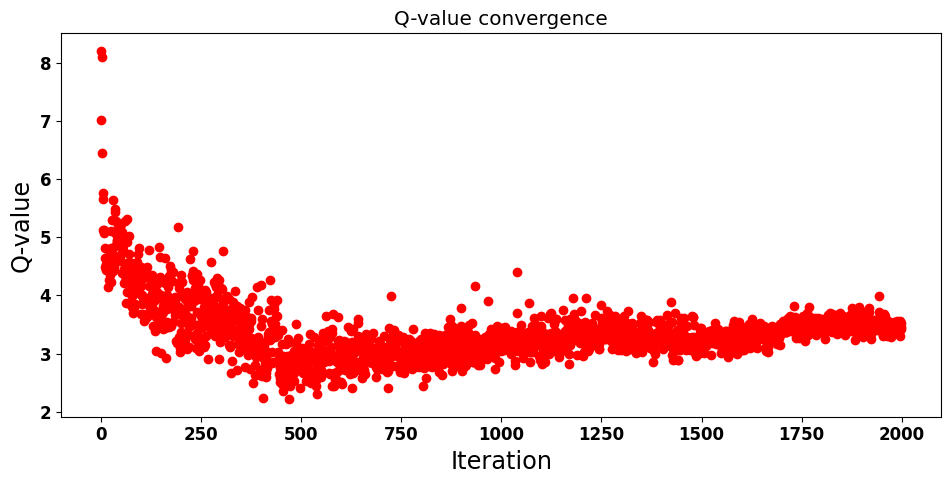

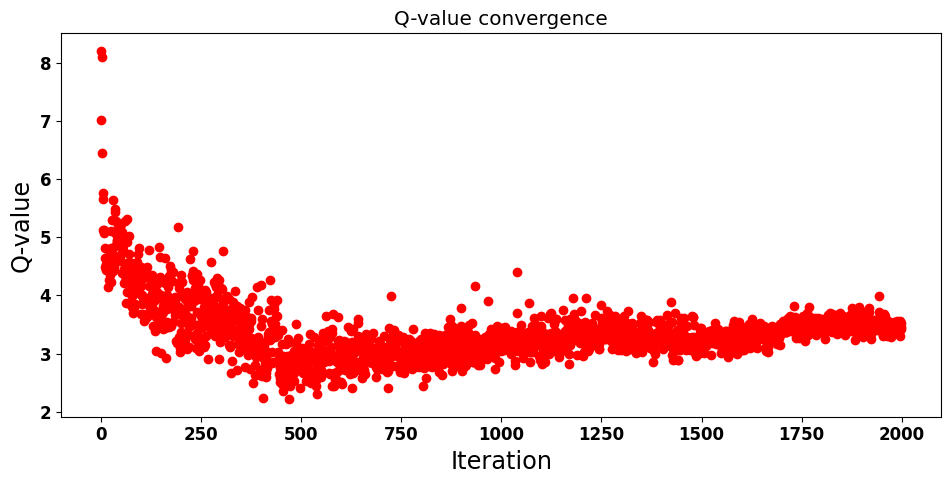

In [19]:
#@title Run conservative Q-iteration (or CQL) with finite data

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 3 # @param {type:"slider", min:0.0, max:10.0, step:0.01}
weights = None
print (weighting_only)
# Run Q-iteration
plt.rcParams.update({'font.size': 12, "font.weight": "bold", 'axes.labelsize': 'x-large'})
fig,axs = plt.subplots(1,1,figsize=(10,5))
axs.set_xlabel('Iteration')
axs.set_ylabel('Q-value')
axs.set_title('Q-value convergence')
plt.tight_layout()
csv_file_name = 'training_results.csv'
OUT_DIR = './results'
output_file_path = os.path.join(OUT_DIR, csv_file_name)
print(output_file_path)
with open(output_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    trained_net = conservative_q_iteration(env, network, fig, axs,
                                        num_itrs=2000, discount=0.9, cql_alpha=cql_alpha_val,
                                        weights=weights, render=False,
                                        sampled=not(weighting_only),
                                        training_dataset=training_dataset_loaded,log_file=csv_writer)



fig.savefig(f'{OUT_DIR}/Q-value_convergence.pdf')
# Compute and plot the value function
# v_values = np.max(q_values, axis=1)
# plot_s_values(env, v_values, title='Values')

In [24]:
def compress_results_folder(results_dir,current_time):
    tar_file_name = f'{results_dir}/training_results_{current_time}.tar'
    
    # Create a tar file
    with tarfile.open(tar_file_name, 'w') as tar:
        # Iterate through the files in the results directory
        for item in os.listdir(results_dir):
            if item.endswith(('.pth', '.csv', '.pdf')):
                item_path = os.path.join(results_dir, item)
                # Check if it's a file (not a directory)
                # if os.path.isfile(item_path):
                tar.add(item_path, arcname=item)  # Add file to tar
                os.remove(item_path)

    print(f"Compressed files into {tar_file_name}")

# Specify the results directory


In [25]:
# training_idx = [500]
# s, a, ns, r = get_tensors(training_dataset, training_idx)
# print(s)
# actions = trained_net(s).detach().numpy()
# argmax = np.argmax(actions, axis=-1)
# print(argmax)
# print([ACTIONS[a] for a in argmax])


# trained_net.print_weights()

torch.save(trained_net.state_dict(), f'{OUT_DIR}/trained_network_weights_{current_time}_{cql_alpha_val}.pth')  # Save the model weights
compress_results_folder(OUT_DIR,current_time)
print("Trained weights have been saved to 'trained_network_weights.pth'")



Compressed files into ./results/training_results_20250106_121521.tar
Trained weights have been saved to 'trained_network_weights.pth'


In [26]:
# columns = ['Progress', 'Power', 'TOT_INS_PER_CYC', 'L3_TCM_PER_TCA', 'TOT_STL_PER_CYC', 
#            'Action', 'Reward', 
#            'Next_Progress', 'Next_Power', 'Next_TOT_INS_PER_CYC', 'Next_L3_TCM_PER_TCA', 'Next_STL_PER_CYC']

# df_training_dataset = pd.DataFrame([list(state) + [action, reward] + list(next_state) for state, action, reward, next_state in training_dataset], columns=columns)

# # Find the maximum value along each column
# max_values = df_training_dataset.max()

# print(max_values)